# Convolutional Neural Networks for MNIST Digit Detection

In this notebook we will learn how to implement a convolutional neural network (CNN) detect digits of the MNIST dataset. We will use the Pytorch library for the implementation, compilation and training of the model.

The input to our model is a $64 \times 64$ image with a MNIST digit at any location, and the output of the model are four real numbers that define a bounding box (x, y, width, and height) around the digit and its class.

### Import necessary modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt

# setup cuda
use_cuda = torch.cuda.is_available()
device = torch.device("mps")
x = torch.ones(1, device=device)
print (x)
print(device)

tensor([1.], device='mps:0')
mps


## Create a custom dataset

First of all we need a custom dataset class to create our training/test samples. This class creates synthetic images by placing MNIST numbers (wich have a size $28 \times 28$) at random locations of a black $64 \times 64$ canvas image.

In [19]:
class MNISTdetectionDataset(Dataset):
    """MNIST localization toy dataset."""

    def __init__(self, imgsize=(64,64), train=True, transform=None):
        """
        Args:
            imgsize (tuple (int,int), optional) - the size of generated images,
                both width and height must be > 48
            train (bool, optional) – If True, creates dataset from MNIST training
                samples, otherwise from test
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        assert len(imgsize)==2 and imgsize[0] > 48 and imgsize[1] > 48
        self.imgsize = imgsize
        self.transform = transform
        self.mnist = datasets.MNIST('../data', train=train, download=True)
        self.classes = [t[1] for t in self.mnist]

    def __len__(self):
        return self.mnist.data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #print(idx)
        image = torch.zeros(self.imgsize)
        digit_img = self.mnist.data[idx,:,:]

        # copy the MNIST digit into a random location
        x_offset = np.random.randint(0,self.imgsize[0]-28)
        y_offset = np.random.randint(0,self.imgsize[1]-28)
        if(idx % 17 == 0):
            image = torch.zeros(self.imgsize)
            image = image.reshape((1,)+self.imgsize)
        else:
            image[y_offset:y_offset+28,x_offset:x_offset+28] = digit_img
            image = image.reshape((1,)+self.imgsize) # must be a tensor image of size (C, H, W)
        
        if self.transform:
            image = self.transform(image)

        # normalize the target values so they are real numbers from 0. to 1.
        bbox = np.array([x_offset / self.imgsize[0], y_offset / self.imgsize[1], 
                         28. / self.imgsize[0], 28. / self.imgsize[1]], dtype=np.float32)
        #y = np.asarray(digit_img[idx]['label'])
        if(idx % 17 == 0):
            sample = {'image': image, 'bbox': np.array([0, 0, 0, 0], dtype = np.float32), 'label': 17}
        else:
            sample = {'image': image, 'bbox': bbox, 'label': self.classes[idx]}

        return sample

Now we can create the necessary Dataset and DataLoader objects as follows.

In [20]:
transform=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = MNISTdetectionDataset(train=True, transform=transform)
dataset2 = MNISTdetectionDataset(train=False, transform=transform)

train_kwargs = {'batch_size': 64}
test_kwargs  = {'batch_size': 1000}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(dataset1, **train_kwargs)
test_loader = DataLoader(dataset2, **test_kwargs)

### Visualize some generated samples

0 torch.Size([1, 64, 64]) (4,)
1 torch.Size([1, 64, 64]) (4,)
2 torch.Size([1, 64, 64]) (4,)
3 torch.Size([1, 64, 64]) (4,)


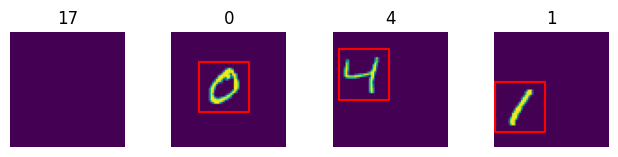

In [21]:
def show_bbox(image, bbox, label, pred=None):
    """Show image with bbox"""
    image = image.squeeze()
    plt.imshow(image)
    plt.title(label)
    # plot the ground truth bounding box
    imgsize = image.shape
    bbox *= [imgsize[0],imgsize[1],imgsize[0],imgsize[1]]
    plt.plot([bbox[0],bbox[0]+bbox[2],bbox[0]+bbox[2],bbox[0],bbox[0]],
             [bbox[1],bbox[1],bbox[1]+bbox[3],bbox[1]+bbox[3],bbox[1]], c='r')

    if pred is not None: 
        # plot the predicted bounding box (if provided)
        pred *= [imgsize[0],imgsize[1],imgsize[0],imgsize[1]]
        plt.plot([pred[0][0],pred[0][0]+pred[0][2],pred[0][0]+pred[0][2],pred[0][0],pred[0][0]],
                 [pred[0][1],pred[0][1],pred[0][1]+pred[0][3],pred[0][1]+pred[0][3],pred[0][1]], c='b')
    
    
 
fig = plt.figure()
for i in range(len(dataset1)):
    sample = dataset1[i]
    print(i, sample['image'].shape, sample['bbox'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_bbox(**sample)

    if i == 3:
        plt.show()
        break

In [22]:
# check the size of the dataset
print("Size of training data: {}".format(len(dataset1)))
print("Size of test data: {}".format(len(dataset2)))

Size of training data: 60000
Size of test data: 10000


We have 60,000 images for training and 10,000 for testing. The image size is $64 \times 64$ pixels and they have only one channel (greyscale images).

## Create the CNN regression + classification model

We will use a simple CNN model with two convolutional layers, one pooling layer, and two fully connected layers. We will use also Dropout to help regularizing the model. 

Notice that the output layer has four neurons with a `sigmoid` and a `softmax` activation, so our model produces at its outputs four real numbers (x,y,width, and height).

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        #Regression
        self.fc1 = nn.Linear(57600, 256)
        self.fc2 = nn.Linear(256, 4)
        #Classification
        self.fc3 = nn.Linear(57600, 256)
        self.fc4 = nn.Linear(256, 10)
        #Confidence
        self.fc5 = nn.Linear(57600, 256)
        self.fc6 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #classification
        x_clf = F.relu(self.fc3(x))
        x_clf = self.fc4(x_clf)
        #regression
        x_reg = self.fc1(x)
        x_reg = F.sigmoid(x_reg)
        x_reg = self.dropout2(x_reg)
        x_reg = self.fc2(x_reg)
        x_reg = F.sigmoid(x_reg)
        #confidence
        x_conf = self.fc5(x)
        x_conf = F.sigmoid(x_conf)
        x_conf = self.fc6(x_conf)
        x_conf = F.sigmoid(x_conf)
        return x_clf,x_reg,x_conf

### Define the training method

For training our CNN regression model we will use the L1 loss, which takes the mean element-wise absolute value difference.

See <a href="https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss">`torch.nn.L1Loss`</a> for details.

In [24]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss_values = []
    criterion_clf = nn.CrossEntropyLoss()
    for batch_idx, sample_batched in enumerate(train_loader):
        data = sample_batched['image']
        target = sample_batched['bbox']
        label = sample_batched['label']
        data, target, label = data.to(device), target.to(device), label.to(device)
        optimizer.zero_grad()
        outputs_clf, outputs_reg, outputs_conf = model(data)
        loss = (F.l1_loss(outputs_reg, target) + criterion_clf(outputs_clf, label))*F.l1_loss(outputs_conf, target)
        loss_values.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss_values

### Train the model

In [25]:
model = Net().to(device)

lr = 0.1
optimizer = optim.Adadelta(model.parameters(), lr=lr)

epochs = 5
lr_gamma = 0.7 # Learning rate step gamma
scheduler = StepLR(optimizer, step_size=1, gamma=lr_gamma)

log_interval = 100 # how many batches to wait before logging training status

loss_history = []
for epoch in range(1, epochs + 1):
    loss_values = train(model, device, train_loader, optimizer, epoch)
    loss_history += loss_values
    scheduler.step()

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1316/4289343161.py:12: UserWarning: Using a target size (torch.Size([64, 4])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = (F.l1_loss(outputs_reg, target) + criterion_clf(outputs_clf, label))*F.l1_loss(outputs_conf, target)
/opt/anaconda3/envs/m5/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678402353079/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Epoch: 1 [0/60000 (0%)]	Loss: 1.429697
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.165272
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.169969
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.129926
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.121724
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.072544
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.075695
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.069369
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.063851
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.047604


/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1316/4289343161.py:12: UserWarning: Using a target size (torch.Size([32, 4])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = (F.l1_loss(outputs_reg, target) + criterion_clf(outputs_clf, label))*F.l1_loss(outputs_conf, target)


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.053353
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.042106
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.025460
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.039601
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.026533
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.028716
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.028595
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.023860
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.035492
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.009841
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.030009
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.027362
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.015571
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.028386
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.019741
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.019130
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.027591
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.020709
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.025828
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.010968
Train Epoch:

### Plot the loss over time

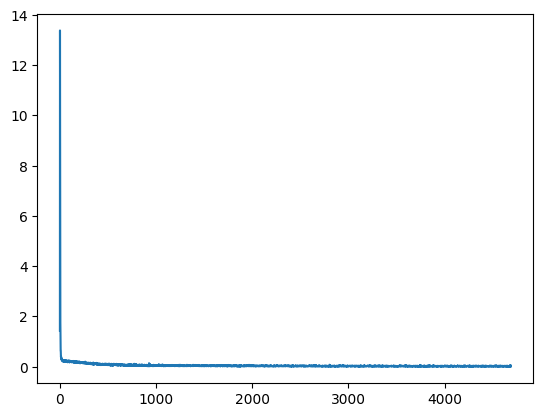

In [26]:
plt.plot(np.arange(len(loss_history)), loss_history)

## Evaluate the model

Finally, we can use the trained model to predict a bounding box for any given image. Let's see how to make predictions for the first four images of the test set.

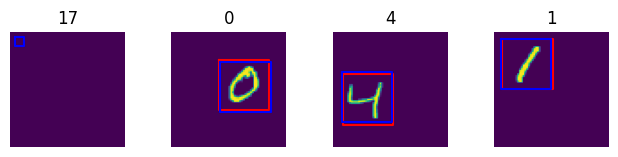

In [27]:
model.eval()

fig = plt.figure()
for i in range(len(dataset1)):
    sample = dataset1[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    # predict the bounding box for a given image
    data = sample['image']
    data = data.reshape((1,)+data.shape) # shape must be (b,c,h,w)
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
    aux = output[1].cpu().numpy()    
    sample['pred'] = output[1].cpu().numpy()
    show_bbox(**sample)

    if i == 3:
        plt.show()
        break

We appreciate that the predicted bounding boxes (blue) are good aproximations of the ground truth (red).

In order to measure whether the results are correct or not in the entire test set we need to implement a performance measure based on the Intersection over Union (IoU) of the ground truth and predicted bounding boxes.

In [28]:
def IoU(pred, target, iou_threshold = 0.7):
    # determine the coordinates of the intersection rectangle
    x_left = np.maximum(pred[:,0], target[:,0])
    y_top = np.maximum(pred[:,1], target[:,1])
    x_right = np.minimum(pred[:,0]+pred[:,2], target[:,0]+target[:,2])
    y_bottom = np.minimum(pred[:,1]+pred[:,3], target[:,1]+target[:,3])
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the areas of the union
    pred_area = pred[:,2] * pred[:,3]
    target_area =  target[:,2] *  target[:,3]
    
    union_area = pred_area + target_area - intersection_area
    
    iou = intersection_area / union_area
    
    return iou>iou_threshold

### Define the test method

In [30]:
def test(model, device, test_loader):
    criterion_clf = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, sample_batched in enumerate(test_loader):
            data = sample_batched['image']
            target = sample_batched['bbox']
            label = sample_batched['label'] 
            data, target, label = data.to(device), target.to(device), label.to(device)
            outputs_clf, outputs_reg, outputs_conf = model(data)
            test_loss += (F.l1_loss(outputs_reg, target).item()+ criterion_clf(outputs_clf, label))*F.l1_loss(outputs_conf, target)
            
            # count the number of prediction with an IoU above a certain threshold
            correct += np.sum(IoU(outputs_reg.cpu().numpy(), target.cpu().numpy(), iou_threshold = 0.7))

    test_loss /= (len(test_loader.dataset)/test_loader.batch_size)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    

# call the test method
test(model, device, test_loader)

/var/folders/d_/0g_w8mls3jb45q24svvm3g_h0000gn/T/ipykernel_1316/2059082246.py:13: UserWarning: Using a target size (torch.Size([1000, 4])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += (F.l1_loss(outputs_reg, target).item()+ criterion_clf(outputs_clf, label))*F.l1_loss(outputs_conf, target)



Test set: Average loss: 0.0112, Accuracy: 9377/10000 (94%)



[[0.03530993 0.03363033 0.07691173 0.0799997 ]] [[0. 0. 0. 0.]] [False]


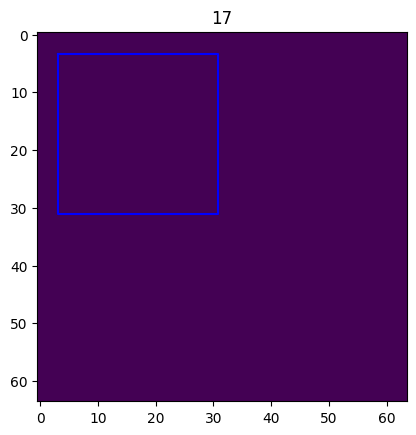

In [32]:
# Find wrong prediction and display it

model.eval()

fig = plt.figure()
plt.tight_layout()
ax.axis('off')

for i in range(len(dataset2)):
    sample = dataset2[i]
    
    # predict the bounding box for a given image
    data = sample['image']
    data = data.reshape((1,)+data.shape) # shape must be (b,c,h,w)
    data = data.to(device)
    with torch.no_grad():
        outputs_reg = model(data)
    #print(outputs_reg)
    
    target = sample['bbox'].reshape((1,4))
    iou= IoU(outputs_reg[1].cpu().numpy(), target, iou_threshold = 0.7)
    
    if not iou:
        print(outputs_reg[1].cpu().numpy(), target,iou)
        sample['pred'] = output[1].cpu().numpy()
        show_bbox(**sample)
        break

plt.show()